# Network Architecture Tuning
### AJ Zerouali, 22/12/10

Goals:

* Find the optimal network architecture for TD3 and SAC corresponding to the timeframe used, by testing various possibilities.
* Write a script to automate this process.

In [1]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch as th
from torch import nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

from typing import Dict, List, Tuple, Type, Union

# *DRL_PfOpt* imports
from drl_pfopt import (FeatureEngineer,
                       YahooDownloader,
                       AlpacaDownloader,
                       data_split,
                       PortfolioOptEnv,
                       PFOpt_DRL_Agent,
                      )
from drl_pfopt.common.benchmarks import get_benchmark_prices_and_returns, get_eq_wts_benchmark
import MyAlpaca

# Experimental dropout policy for TD3
#from TD3_Dropout_XP import DropOutMlpPolicy
from TD3_Dropout_XP import TD3DropOutPolicy
# Experimental dropout policy for SAC
from SAC_Dropout_XP import SACDropOutPolicy


# 10 stock dataset

In [35]:
EX1_TICKER_LIST = MyAlpaca.EX_1_LIST
start_date = "2008-01-01"
end_date = "2022-07-01"
downloader = YahooDownloader()

In [36]:
df_data = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = EX1_TICKER_LIST,)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (36500, 7)


In [37]:
day_list = list(df_data.date.unique())

In [38]:
len(day_list)

3650

In [39]:
df_data.head()

,date,open,high,low,close,volume,tic
0,2008-01-02,42.490002,42.720001,41.049999,33.615849,3144900,AMT
1,2008-01-02,52.090000,52.320000,50.790001,40.173489,8053700,AXP
2,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA
3,2008-01-02,93.959999,94.690002,92.709999,52.227066,9058000,CVX
4,2008-01-02,66.559998,67.000000,65.720001,42.433327,11970500,JNJ


In [40]:
len(df_data.tic.unique())

10

In [41]:
df_data.to_csv(path_or_buf = "datasets/EX1_LIST_data_0801-2206.csv")

# Data

In [2]:
# Load Dow Jones data
#df_file = pd.read_csv(filepath_or_buffer="datasets/DJIA30_data_0801-0908.csv",
#                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Load EX!_LIST data (datasets/EX1_LIST_data_0801-2206.csv)
df_file = pd.read_csv(filepath_or_buffer="datasets/EX1_LIST_data_0801-2206.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Setup FeatureEngineer() processor
processor = FeatureEngineer(tech_indicator_list = ['turbulence'],
                            use_return_covs = True,
                            n_lookback_prds = 60,
                            data_source = "Yahoo")

# Get processed data
processed_data_dict = processor.preprocess_data(df_file)
df_X = processed_data_dict["df"]
ret_X = processed_data_dict["np_close_returns"]
cov_X = processed_data_dict["np_returns_covs"]

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [3]:
print(f"list(df_X.date.unique())[0] = {list(df_X.date.unique())[0]}")

list(df_X.date.unique())[0] = 2008-03-31


In [3]:
# Train, validation and test dates
start_train_date = '2015-07-01'
end_train_date = '2020-07-01'
start_val_date = end_train_date
end_val_date = "2020-09-01"
start_test_date = end_train_date
end_test_date = '2021-01-01'

# Data splits
df_train, ret_X_train, cov_X_train = data_split(df_X = df_X, 
                                                start=start_train_date, 
                                                end = end_train_date,
                                                use_returns_cov = True,
                                                ret_X= ret_X,
                                                cov_X=cov_X)

df_val, ret_X_val, cov_X_val = data_split(df_X = df_X,
                                          start=start_val_date, 
                                          end = end_val_date,
                                          use_returns_cov = True,
                                          ret_X= ret_X,
                                          cov_X=cov_X)

df_test, ret_X_test, cov_X_test = data_split(df_X = df_X,
                                             start=start_test_date,
                                             end = end_test_date,
                                             use_returns_cov = True,
                                             ret_X= ret_X,
                                             cov_X=cov_X)

Dataframe, returns and cov have same number of dates
Dataframe, returns and cov have same number of dates
Dataframe, returns and cov have same number of dates


### Environments

In [4]:
env_kwargs = {
    "n_lookback_prds": 60,
    "pf_value_ini" : 1000000,
    "reward_type": 'portfolio_return',
    "state_struct_list" : ['close_returns', 'weights'],
    "tech_ind_list": [],
    "transaction_cost_pct" : 0,
    "weight_normalization": "softmax",
    "plot_prds_end_episode": 40,
    }

train_env_ret = PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            ret_X = ret_X_train,
            **env_kwargs)

val_env_ret = PortfolioOptEnv(
            df_X = df_val,
            cov_X = cov_X_val,
            ret_X = ret_X_val,
            **env_kwargs)

test_env_ret = PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            ret_X = ret_X_test,
            **env_kwargs)

**Return scaling:**

As a test, we multiply the returns by 100 to avoid numerical issues.

In [5]:
# Training data
train_env_ret.X[:,train_env_ret.state_idx_dict['close_returns'],:] \
= train_env_ret.X[:,train_env_ret.state_idx_dict['close_returns'],:]*100.0

# Validation data
val_env_ret.X[:,val_env_ret.state_idx_dict['close_returns'],:] \
= val_env_ret.X[:,val_env_ret.state_idx_dict['close_returns'],:]*100.0

# Testing data
test_env_ret.X[:,test_env_ret.state_idx_dict['close_returns'],:] \
= test_env_ret.X[:,test_env_ret.state_idx_dict['close_returns'],:]*100.0

### Benchmarks

#### Validation period

x) Dow Jones

In [11]:
df_DJI_benchmark_val, df_DJI_returns_val = get_benchmark_prices_and_returns(ticker = "^DJI", 
                                                                    start_date = start_val_date, 
                                                                    end_date = end_val_date,
                                                                    data_source="Yahoo")
DJI_cumul_return_val = (df_DJI_benchmark_val['close'].iloc[-1]\
                    -df_DJI_benchmark_val['close'].iloc[0])/(df_DJI_benchmark_val['close'].iloc[0])
DJI_Sharpe_val = (np.sqrt(252)*df_DJI_returns_val['daily_return'].to_numpy().mean())\
    /(df_DJI_returns_val['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret. (Validation): {DJI_cumul_return_val}")
print(f"Benchmark Sharpe ratio (Valication): {DJI_Sharpe_val}")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (43, 7)
Benchmark cumul. ret. (Validation): 0.1047244276752853
Benchmark Sharpe ratio (Valication): 4.72512394796699


a) SPY

In [12]:
df_SPY_benchmark_val, df_SPY_returns_val = get_benchmark_prices_and_returns(ticker = "SPY", 
                                                                    start_date = start_val_date, 
                                                                    end_date = end_val_date,
                                                                    data_source="Yahoo")
SPY_cumul_return_val = (df_SPY_benchmark_val['close'].iloc[-1]\
                    -df_SPY_benchmark_val['close'].iloc[0])/(df_SPY_benchmark_val['close'].iloc[0])
SPY_Sharpe_val = (np.sqrt(252)*df_SPY_returns_val['daily_return'].to_numpy().mean())\
    /(df_SPY_returns_val['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret. (Validation): {SPY_cumul_return_val}")
print(f"Benchmark Sharpe ratio (Valication): {SPY_Sharpe_val}")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (43, 7)
Benchmark cumul. ret. (Validation): 0.12491955143832277
Benchmark Sharpe ratio (Valication): 6.826510178218943


b) Equal weights portfolio

Initial portfolio value: 1000000
End portfolio value: 1061518.122608881
Yearly Sharpe ratio at last period: 2.7533528056400143
Plotting portfolio values and weights for last 40 periods:


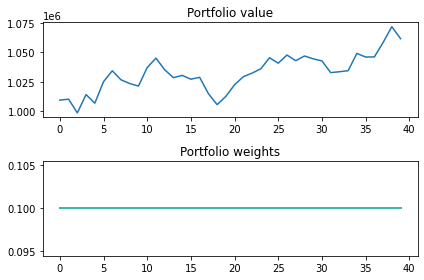

In [6]:
ew_val_benchmark_results_dict = get_eq_wts_benchmark(env = val_env_ret)

In [7]:
ew_val_benchmark_results_dict.keys()

dict_keys(['value_hist', 'return_hist', 'Sharpe_ratio', 'performance_stats'])

In [6]:
ew_val_benchmark_results_dict["performance_stats"]

,Value
Annual return,0.418883
Cumulative returns,0.061518
Annual volatility,0.131772
Sharpe ratio,2.721149
Calmar ratio,11.136763
Stability,0.648046
Max drawdown,-0.037613
Omega ratio,1.531138
Sortino ratio,4.807464
Skew,0.240114


#### Testing period

a) Dow Jones

In [14]:
df_DJI_benchmark_test, df_DJI_returns_test = get_benchmark_prices_and_returns(ticker = "^DJI", 
                                                                    start_date = start_test_date, 
                                                                    end_date = end_test_date,
                                                                    data_source="Yahoo")
DJI_cumul_return_test = (df_DJI_benchmark_test['close'].iloc[-1]\
                    -df_DJI_benchmark_test['close'].iloc[0])/(df_DJI_benchmark_test['close'].iloc[0])
DJI_Sharpe_test = (np.sqrt(252)*df_DJI_returns_test['daily_return'].to_numpy().mean())\
    /(df_DJI_returns_test['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret. (Validation): {DJI_cumul_return_test}")
print(f"Benchmark Sharpe ratio (Validation): {DJI_Sharpe_test}")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (128, 7)
Benchmark cumul. ret. (Validation): 0.1892953297605057
Benchmark Sharpe ratio (Validation): 2.205322153615822


a) SPY

In [11]:
df_SPY_benchmark_test, df_SPY_returns_test = get_benchmark_prices_and_returns(ticker = "SPY", 
                                                                    start_date = start_test_date, 
                                                                    end_date = end_test_date,
                                                                    data_source="Yahoo")
SPY_cumul_return_test = (df_SPY_benchmark_test['close'].iloc[-1]\
                    -df_SPY_benchmark_test['close'].iloc[0])/(df_SPY_benchmark_test['close'].iloc[0])
SPY_Sharpe_test = (np.sqrt(252)*df_SPY_returns_test['daily_return'].to_numpy().mean())\
    /(df_SPY_returns_test['daily_return'].to_numpy().std())
print(f"Benchmark cumul. ret. (Validation): {SPY_cumul_return_test}")
print(f"Benchmark Sharpe ratio (Valication): {SPY_Sharpe_test}")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (128, 7)
Benchmark cumul. ret. (Validation): 0.21401765398992362
Benchmark Sharpe ratio (Valication): 2.4938946885280444


b) Equal weights portfolio

Initial portfolio value: 1000000
End portfolio value: 1127908.656870601
Yearly Sharpe ratio at last period: 1.4321638029429573
Plotting portfolio values and weights for last 40 periods:


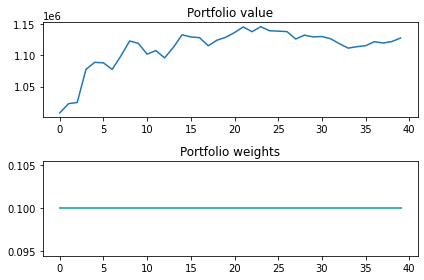

In [7]:
ew_test_benchmark_results_dict = get_eq_wts_benchmark(env = test_env_ret)

In [10]:
ew_test_benchmark_results_dict["performance_stats"]

,Value
Annual return,0.267402
Cumulative returns,0.127909
Annual volatility,0.177056
Sharpe ratio,1.426558
Calmar ratio,2.735534
Stability,0.513321
Max drawdown,-0.097751
Omega ratio,1.270022
Sortino ratio,2.216667
Skew,0.353071


# Seeds - Top 5 and worst 5

**Seeds: TD3**

In [23]:
df_TD3_Seeds = pd.read_csv("results/TD3_OHCLVW_SftMx_Seeds_0-250_221105.csv")

In [24]:
df_TD3_Seeds.columns

Index(['Unnamed: 0', 'Seed', 'Training final val.', 'Training Sharpe',
       'Test cumul. ret.', 'Test Sharpe'],
      dtype='object')

In [25]:
df_TD3_Seeds = df_TD3_Seeds.sort_values(by = ['Test cumul. ret.', 'Test Sharpe'])

In [26]:
df_TD3_Seeds.head()

,Unnamed: 0,Seed,Training final val.,Training Sharpe,Test cumul. ret.,Test Sharpe
175,175,199,5.935962e+06,0.960459,0.351242,1.948623
30,30,37,6.023523e+06,0.970236,0.353246,1.947293
28,28,35,5.993111e+06,0.964622,0.360309,2.017348
98,98,117,5.731935e+06,0.944329,0.366076,2.031900
0,0,0,6.014091e+06,0.963183,0.367341,1.964711


In [27]:
df_TD3_Seeds.tail()

,Unnamed: 0,Seed,Training final val.,Training Sharpe,Test cumul. ret.,Test Sharpe
169,169,193,6.544245e+06,0.968368,0.465085,2.342481
109,109,129,6.906564e+06,0.963469,0.467653,2.244864
185,185,209,6.488959e+06,0.934085,0.476030,2.329992
142,142,164,6.581745e+06,0.968853,0.477751,2.441029
100,100,119,6.851120e+06,0.973372,0.492377,2.469811


**Seeds: SAC**

In [28]:
df_SAC_Seeds = pd.read_csv("results/SAC_OHCLVW_SftMx_Seeds_0-200_221106.csv")

In [29]:
df_SAC_Seeds.columns

Index(['Unnamed: 0', 'Seed', 'Training final val.', 'Training Sharpe',
       'Test cumul. ret.', 'Test Sharpe'],
      dtype='object')

In [30]:
df_SAC_Seeds = df_SAC_Seeds.sort_values(by = ['Test cumul. ret.', 'Test Sharpe'])

In [31]:
df_SAC_Seeds.tail()

,Unnamed: 0,Seed,Training final val.,Training Sharpe,Test cumul. ret.,Test Sharpe
25,25,28,6.759453e+06,0.979186,0.452192,2.270100
29,29,32,5.855896e+06,0.919113,0.454101,2.287625
40,40,44,6.978729e+06,1.030763,0.455168,2.474266
147,147,174,7.203326e+06,1.025888,0.458602,2.449490
167,167,196,6.527568e+06,0.959837,0.474533,2.341548


In [32]:
df_SAC_Seeds.head()

,Unnamed: 0,Seed,Training final val.,Training Sharpe,Test cumul. ret.,Test Sharpe
50,50,60,5.800688e+06,0.960023,0.349395,1.926196
121,121,145,5.571630e+06,0.949528,0.355895,2.043569
95,95,117,5.897646e+06,0.966146,0.361292,2.073940
96,96,118,6.207576e+06,0.993221,0.363084,2.052185
127,127,152,6.344285e+06,0.989868,0.363840,2.007181


# TD3 Agent

### Agent

In [78]:
del TD3_WRet

In [8]:
TD3_WRet = PFOpt_DRL_Agent(train_env=train_env_ret)

In [9]:
n_lookback_prds = env_kwargs["n_lookback_prds"]
n_assets = train_env_ret.n_assets

In [10]:
TD3_POLICY = TD3DropOutPolicy
TD3_POLICY_KWARGS = {"n_critics":1,
                     "add_input_dropout":True,
                     "net_arch":[2*(n_lookback_prds+1)*n_assets, 10*n_assets],
                     "dropout_probs_list":[0.5,0.5,0.5],
                    }
TD3_MODEL_KWARGS = {"batch_size": 64, 
              "buffer_size": 10000,
              "learning_rate": 0.001,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              #"action_noise":"ornstein_uhlenbeck",
                   }


In [11]:
TD3_WRet.set_model(model_name = "td3",
                   seed = 119,
                   policy = TD3_POLICY,
                   policy_kwargs=TD3_POLICY_KWARGS,
                   model_kwargs=TD3_MODEL_KWARGS,)

{'batch_size': 64, 'buffer_size': 10000, 'learning_rate': 0.001, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

In [12]:
TD3_WRet.model.policy

TD3DropOutPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mu): Sequential(
      (0): Linear(in_features=610, out_features=1220, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1220, out_features=100, bias=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=10, bias=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Tanh()
    )
  )
  (actor_target): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mu): Sequential(
      (0): Linear(in_features=610, out_features=1220, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1220, out_features=100, bias=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=10, bias=True)
    

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 1972083.555582763

Yearly Sharpe ratio at last period: 0.7947521538476748

=================================

Plotting portfolio values and weights for last 40 periods:

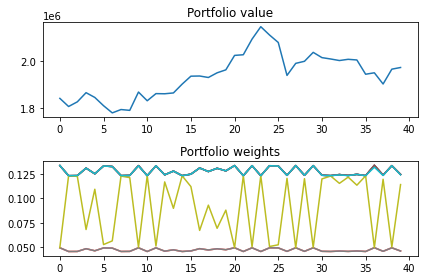

=================================

Initial portfolio value: 1000000

End portfolio value: 2127748.4907418555

Yearly Sharpe ratio at last period: 0.8759006179592723

=================================

Plotting portfolio values and weights for last 40 periods:

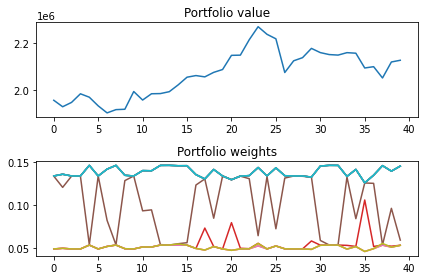

=================================

Initial portfolio value: 1000000

End portfolio value: 2247246.1050191596

Yearly Sharpe ratio at last period: 0.9265565729075971

=================================

Plotting portfolio values and weights for last 40 periods:

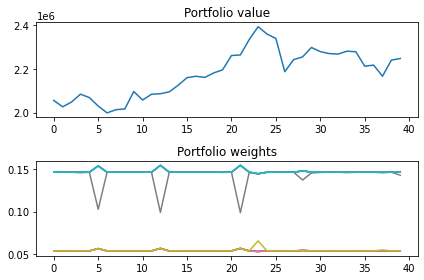

=================================

Initial portfolio value: 1000000

End portfolio value: 2251141.2088973573

Yearly Sharpe ratio at last period: 0.9253267987092202

=================================

Plotting portfolio values and weights for last 40 periods:

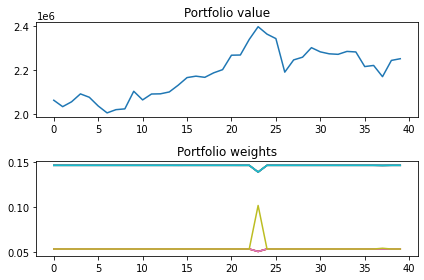

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 0.863    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 124      |
|    time_elapsed    | 40       |
|    total_timesteps | 5036     |
| train/             |          |
|    actor_loss      | -0.00144 |
|    critic_loss     | 0.000121 |
|    learning_rate   | 0.001    |
|    n_updates       | 5030     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 2200629.643616672

Yearly Sharpe ratio at last period: 0.9048354808088462

=================================

Plotting portfolio values and weights for last 40 periods:

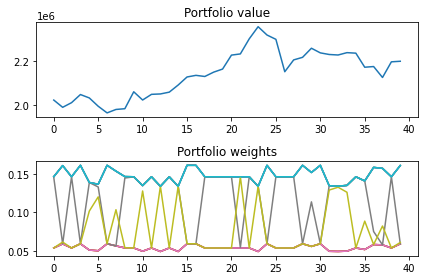

=================================

Initial portfolio value: 1000000

End portfolio value: 2220421.8516897513

Yearly Sharpe ratio at last period: 0.915134552665896

=================================

Plotting portfolio values and weights for last 40 periods:

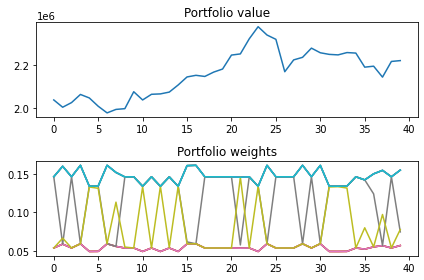

=================================

Initial portfolio value: 1000000

End portfolio value: 2222015.1812456427

Yearly Sharpe ratio at last period: 0.9147269338943189

=================================

Plotting portfolio values and weights for last 40 periods:

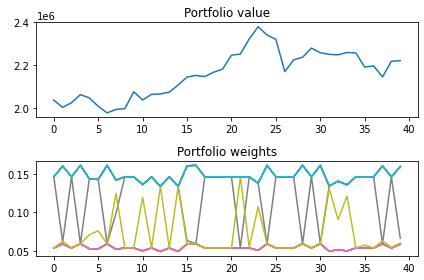

=================================

Initial portfolio value: 1000000

End portfolio value: 2196649.252599643

Yearly Sharpe ratio at last period: 0.9086980596945895

=================================

Plotting portfolio values and weights for last 40 periods:

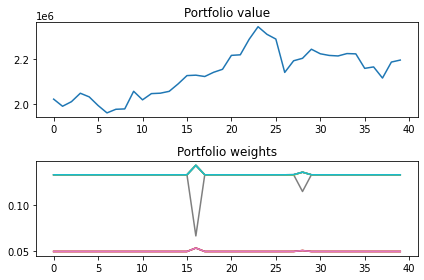

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.26e+03  |
|    ep_rew_mean     | 0.878     |
| time/              |           |
|    episodes        | 8         |
|    fps             | 126       |
|    time_elapsed    | 79        |
|    total_timesteps | 10072     |
| train/             |           |
|    actor_loss      | -0.000731 |
|    critic_loss     | 0.000157  |
|    learning_rate   | 0.001     |
|    n_updates       | 10065     |
----------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 2169534.0489129145

Yearly Sharpe ratio at last period: 0.898089792736685

=================================

Plotting portfolio values and weights for last 40 periods:

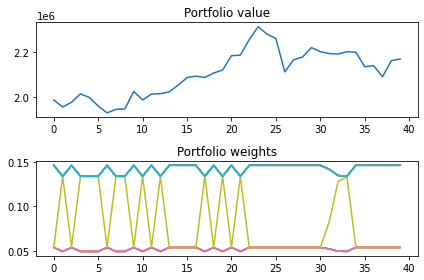

=================================

Initial portfolio value: 1000000

End portfolio value: 2228509.264367982

Yearly Sharpe ratio at last period: 0.919672041036313

=================================

Plotting portfolio values and weights for last 40 periods:

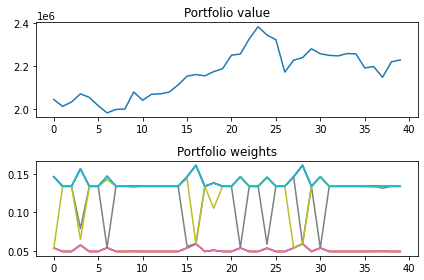

=================================

Initial portfolio value: 1000000

End portfolio value: 2257426.0317014824

Yearly Sharpe ratio at last period: 0.932502016562753

=================================

Plotting portfolio values and weights for last 40 periods:

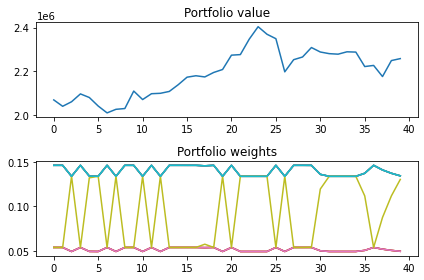

=================================

Initial portfolio value: 1000000

End portfolio value: 2255180.6224401477

Yearly Sharpe ratio at last period: 0.930293804292658

=================================

Plotting portfolio values and weights for last 40 periods:

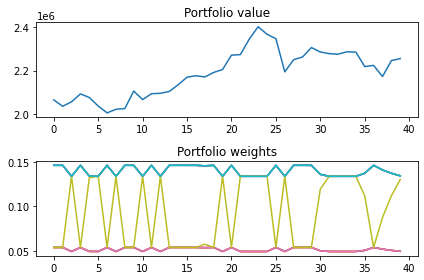

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.26e+03  |
|    ep_rew_mean     | 0.885     |
| time/              |           |
|    episodes        | 12        |
|    fps             | 128       |
|    time_elapsed    | 117       |
|    total_timesteps | 15108     |
| train/             |           |
|    actor_loss      | -0.000818 |
|    critic_loss     | 0.000146  |
|    learning_rate   | 0.001     |
|    n_updates       | 15100     |
----------------------------------


In [13]:
%matplotlib inline
TD3_WRet.train_model(tb_log_name='td3',
                     n_train_rounds=12,
                     progress_bar=True,
                    )

Validation period:

Initial portfolio value: 1000000
End portfolio value: 1057727.6061798462
Yearly Sharpe ratio at last period: 2.7382505646484194
Plotting portfolio values and weights for last 40 periods:


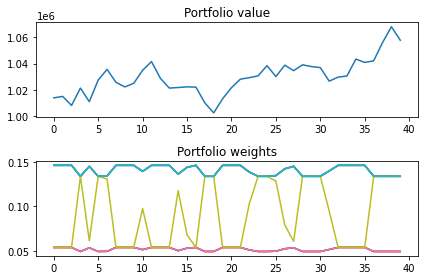

Finished running backtest. Storing results...


In [14]:
val_backtest_result_dict = TD3_WRet.run_backtest(test_env = val_env_ret)

Start date,2020-07-01
End date,2020-08-31
Total months,2
,Backtest
Annual return,38.9%
Cumulative returns,5.8%
Annual volatility,12.4%
Sharpe ratio,2.71
Calmar ratio,10.43
Stability,0.55
Max drawdown,-3.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.74,2020-07-22,2020-07-31,2020-08-24,24
1,1.29,2020-07-15,2020-07-17,2020-07-22,6
2,1.01,2020-07-10,2020-07-13,2020-07-14,3
3,0.96,2020-08-28,2020-08-31,NaT,NaN
4,0.90,2020-07-06,2020-07-09,2020-07-10,5


Stress Events,mean,min,max
New Normal,0.13%,-1.22%,1.62%


True

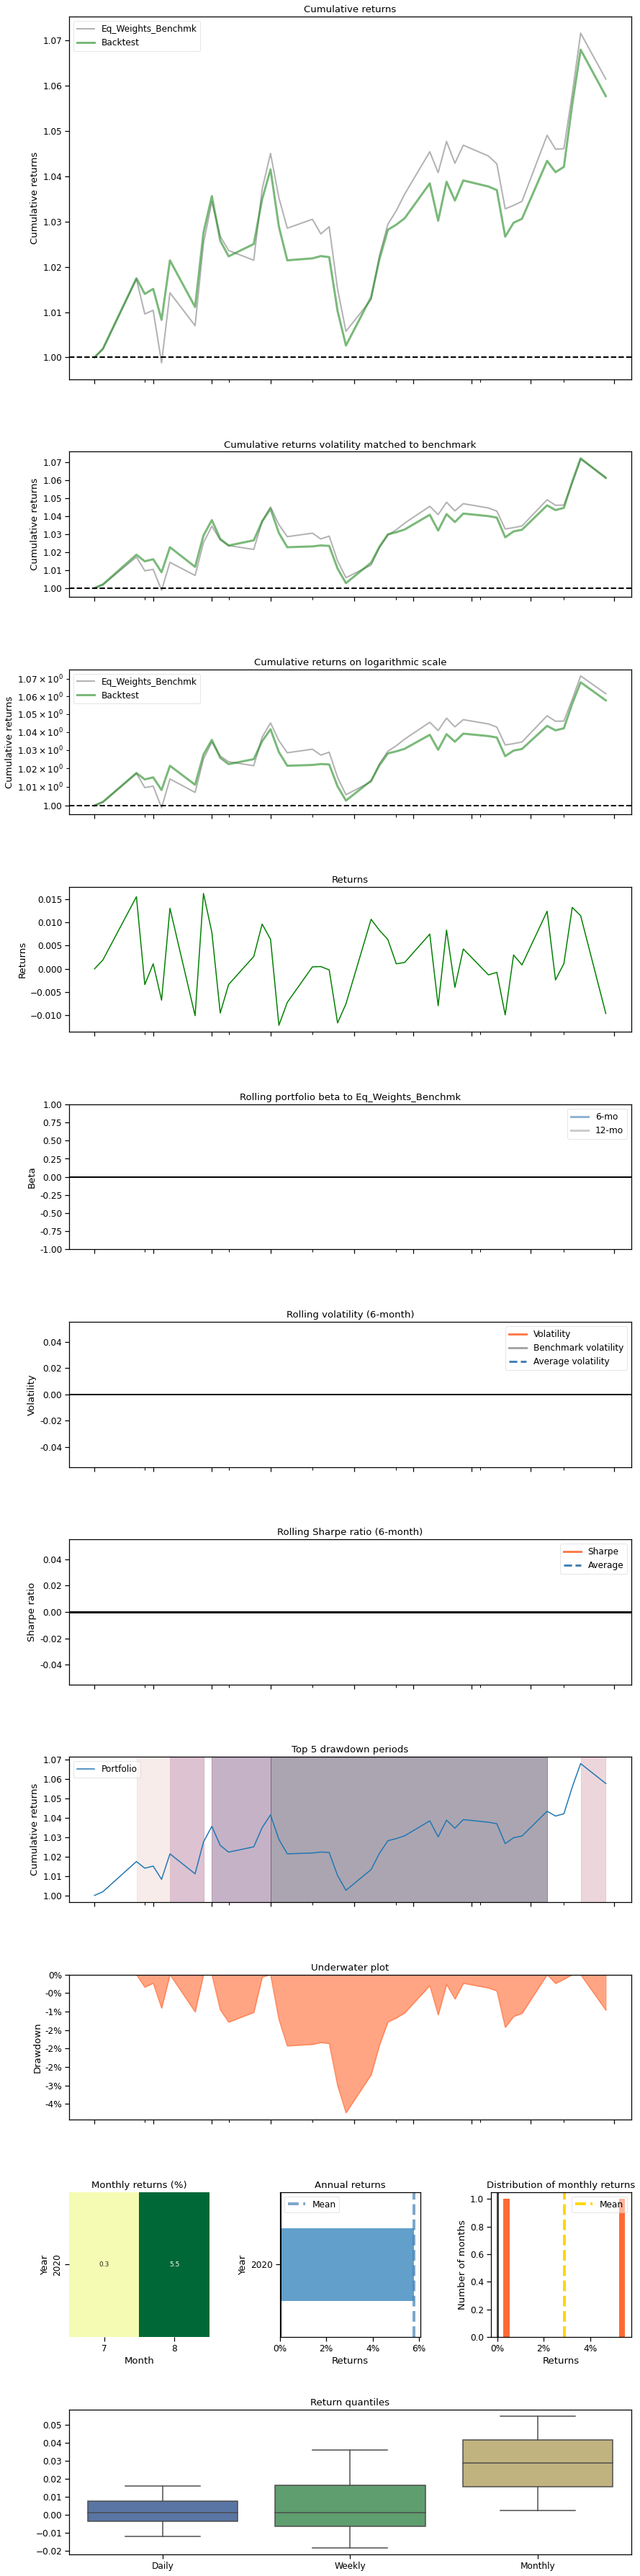

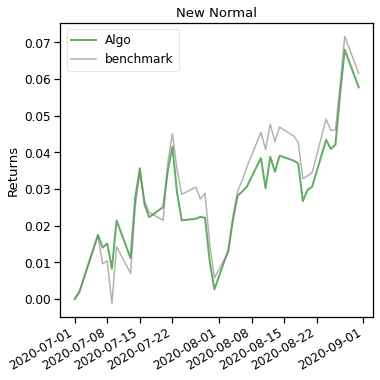

In [15]:
TD3_WRet.plot_backtest_results(df_benchmark_returns=ew_val_benchmark_results_dict["return_hist"],
                               benchmark_name = "Eq_Weights_Benchmk")

<AxesSubplot:>

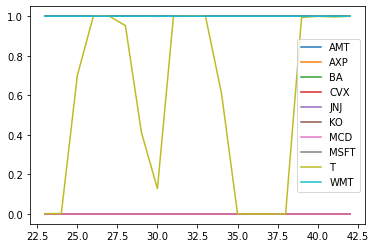

In [16]:
val_backtest_result_dict["agt_actions_hist"].iloc[-20:].plot()

Testing period:

Deleting previous backtest results and history...
Initial portfolio value: 1000000
End portfolio value: 1109512.4368429827
Yearly Sharpe ratio at last period: 1.3001262076381646
Plotting portfolio values and weights for last 40 periods:


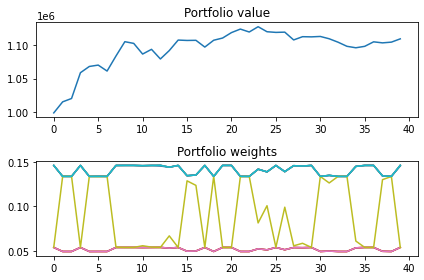

Finished running backtest. Storing results...


In [17]:
test_backtest_result_dict = TD3_WRet.run_backtest(test_env = test_env_ret)

Start date,2020-07-01
End date,2020-12-31
Total months,6
,Backtest
Annual return,22.7%
Cumulative returns,11.0%
Annual volatility,16.9%
Sharpe ratio,1.30
Calmar ratio,2.12
Stability,0.43
Max drawdown,-10.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.71,2020-09-02,2020-10-30,2020-11-13,53
1,3.74,2020-07-22,2020-07-31,2020-08-24,24
2,2.79,2020-12-08,2020-12-23,NaT,NaN
3,2.33,2020-11-16,2020-11-20,2020-11-24,7
4,1.29,2020-07-15,2020-07-17,2020-07-22,6


Stress Events,mean,min,max
New Normal,0.09%,-3.28%,3.77%


True

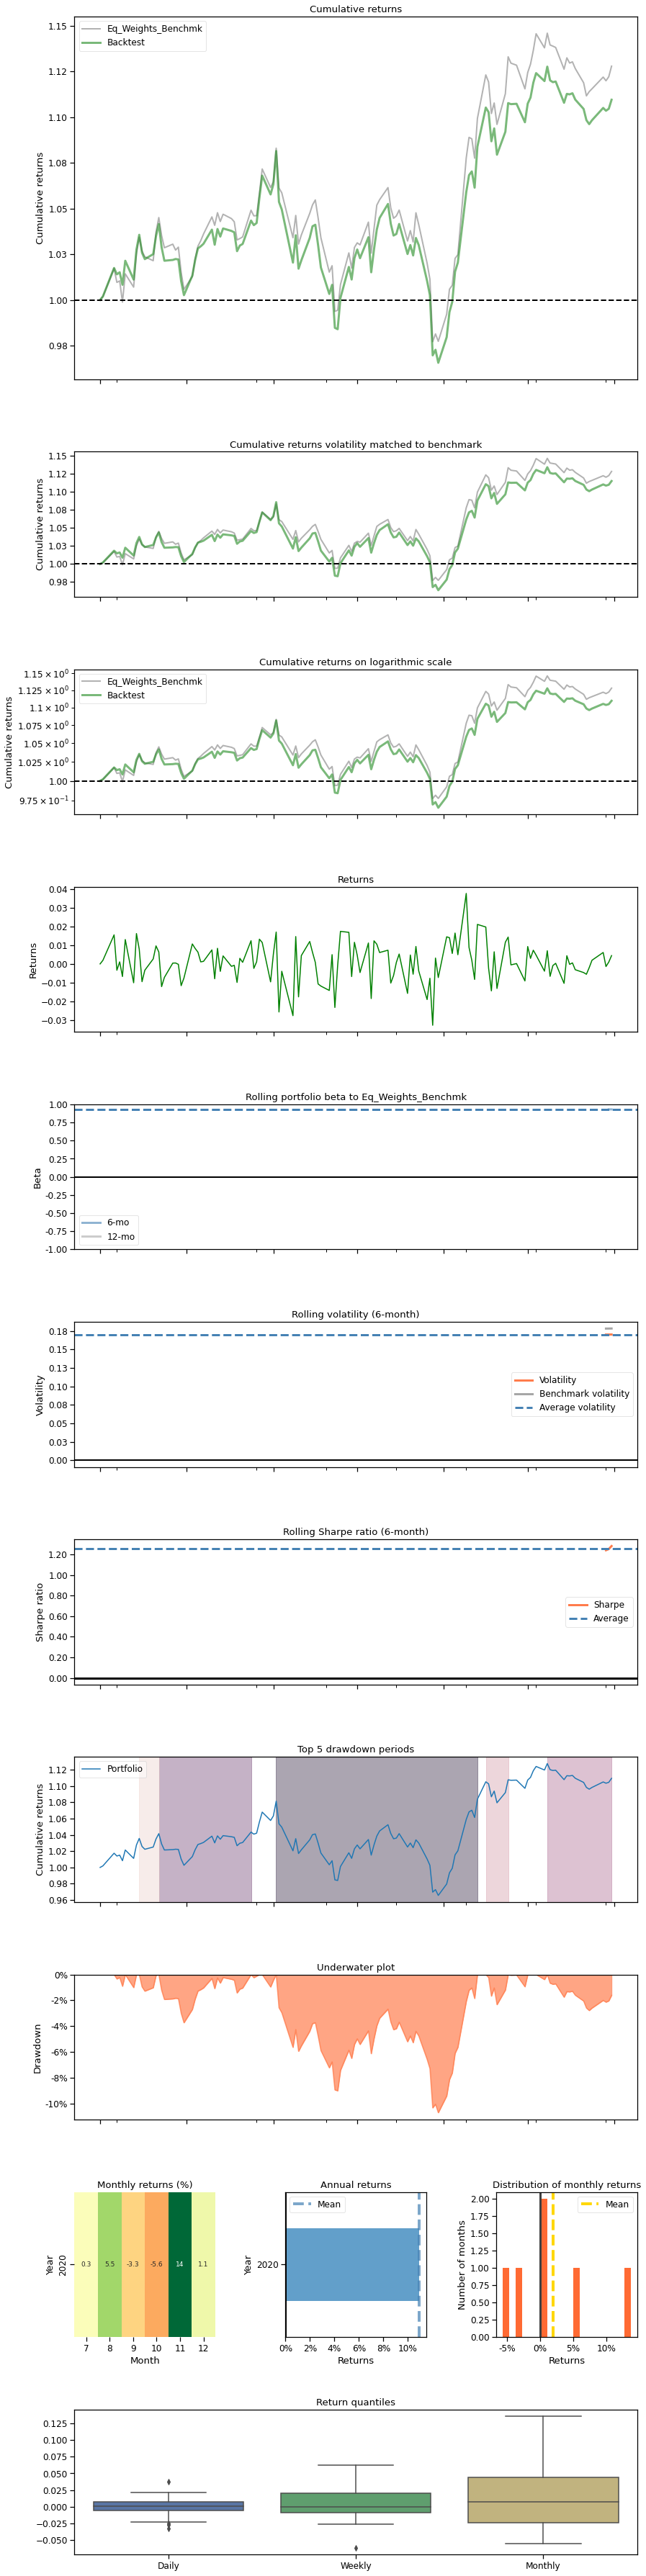

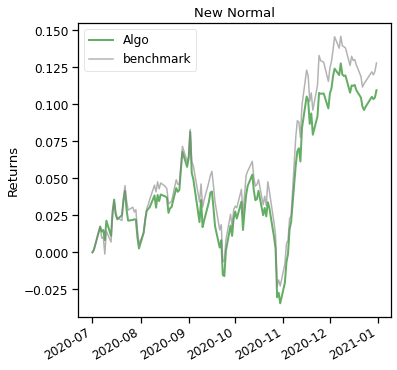

In [18]:
TD3_WRet.plot_backtest_results(df_benchmark_returns=ew_test_benchmark_results_dict["return_hist"],
                               benchmark_name = "Eq_Weights_Benchmk")

<AxesSubplot:>

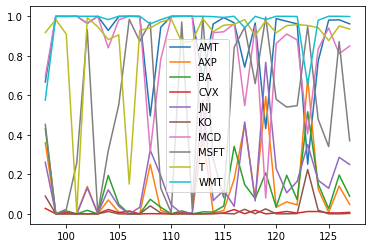

In [27]:
test_backtest_result_dict["agt_actions_hist"].iloc[-30:].plot()

# SAC Agent

### Agent

In [120]:
del SAC_WRet

In [19]:
SAC_WRet = PFOpt_DRL_Agent(train_env=train_env_ret)

In [20]:
n_lookback_prds = env_kwargs["n_lookback_prds"]
n_assets = train_env_ret.n_assets

In [21]:
SAC_POLICY = SACDropOutPolicy
SAC_POLICY_KWARGS = {"n_critics":1,
                     "add_input_dropout":True,
                     "net_arch":dict(qf = [2*(n_lookback_prds+2)*n_assets, 10*n_assets],
                                     pi = [2*(n_lookback_prds+1)*n_assets, 10*n_assets],
                                    ),
                     "dropout_probs_list":dict(qf=[0.5,0.5,0.0],
                                               pi = [0.5,0.5,0.5],
                                              ),
                    }
SAC_MODEL_KWARGS = {"batch_size": 32, 
                    "buffer_size": 10000,
                    "learning_rate": 0.001,
                    "ent_coef": 'auto',
                    "gamma":0,
                    "train_freq": (5, "step"),
                    "learning_starts":5,
                    "action_noise":"ornstein_uhlenbeck",
                   }


In [22]:
SAC_WRet.set_model(model_name = "sac",
                   seed = 196,
                   policy = SAC_POLICY,
                   policy_kwargs=SAC_POLICY_KWARGS,
                   model_kwargs=SAC_MODEL_KWARGS,)

{'batch_size': 32, 'buffer_size': 10000, 'learning_rate': 0.001, 'ent_coef': 'auto', 'gamma': 0, 'train_freq': (5, 'step'), 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

In [23]:
SAC_WRet.model.policy

SACDropOutPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=610, out_features=1220, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1220, out_features=100, bias=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): ReLU()
    )
    (mu): Linear(in_features=100, out_features=10, bias=True)
    (log_std): Linear(in_features=100, out_features=10, bias=True)
  )
  (critic): DropOutContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=620, out_features=1240, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1240, out_features=100, bias=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=100, out_f

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 1917126.4380107678

Yearly Sharpe ratio at last period: 0.7594045661766902

=================================

Plotting portfolio values and weights for last 40 periods:

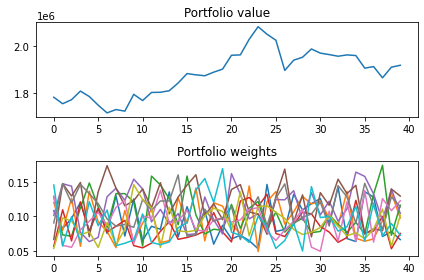

=================================

Initial portfolio value: 1000000

End portfolio value: 1972709.1143409372

Yearly Sharpe ratio at last period: 0.7883311180604082

=================================

Plotting portfolio values and weights for last 40 periods:

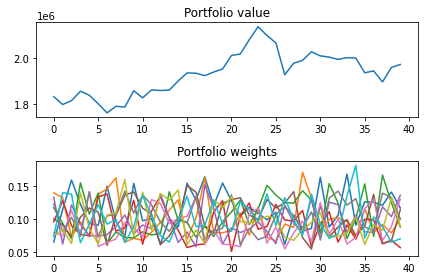

=================================

Initial portfolio value: 1000000

End portfolio value: 1932341.3325827403

Yearly Sharpe ratio at last period: 0.775152869750109

=================================

Plotting portfolio values and weights for last 40 periods:

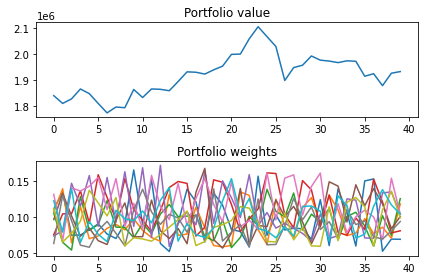

=================================

Initial portfolio value: 1000000

End portfolio value: 1952686.3602152166

Yearly Sharpe ratio at last period: 0.7777311583414266

=================================

Plotting portfolio values and weights for last 40 periods:

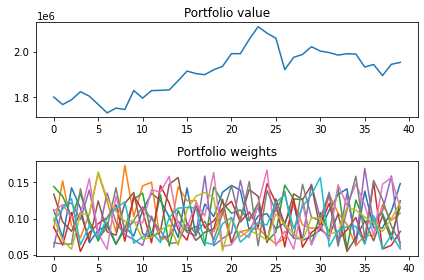

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 0.767    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 266      |
|    time_elapsed    | 18       |
|    total_timesteps | 5036     |
| train/             |          |
|    actor_loss      | -2.51    |
|    critic_loss     | 3.82e-05 |
|    ent_coef        | 0.365    |
|    ent_coef_loss   | -17      |
|    learning_rate   | 0.001    |
|    n_updates       | 1006     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 1956119.772796101

Yearly Sharpe ratio at last period: 0.7761450056273163

=================================

Plotting portfolio values and weights for last 40 periods:

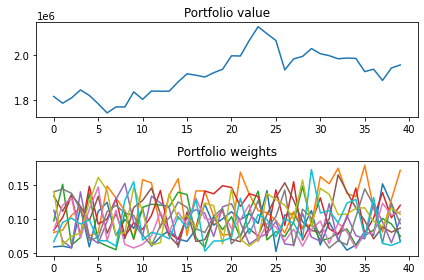

=================================

Initial portfolio value: 1000000

End portfolio value: 2041207.9430766895

Yearly Sharpe ratio at last period: 0.8377993096383095

=================================

Plotting portfolio values and weights for last 40 periods:

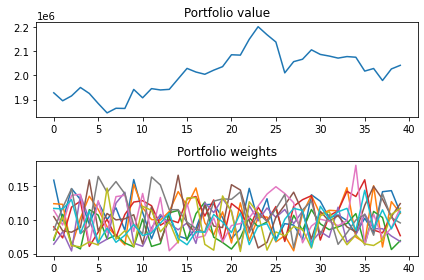

=================================

Initial portfolio value: 1000000

End portfolio value: 1942163.9683861295

Yearly Sharpe ratio at last period: 0.781718480924054

=================================

Plotting portfolio values and weights for last 40 periods:

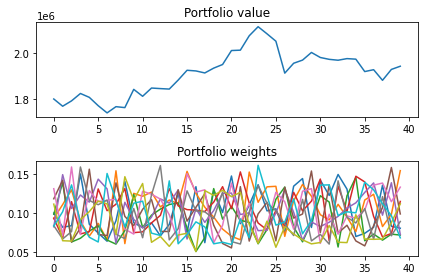

=================================

Initial portfolio value: 1000000

End portfolio value: 1996530.8401628507

Yearly Sharpe ratio at last period: 0.8044309037177892

=================================

Plotting portfolio values and weights for last 40 periods:

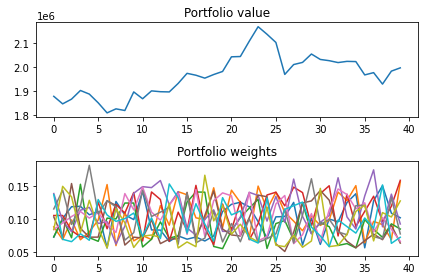

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 0.778    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 267      |
|    time_elapsed    | 37       |
|    total_timesteps | 10072    |
| train/             |          |
|    actor_loss      | -0.92    |
|    critic_loss     | 0.000126 |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | -34.1    |
|    learning_rate   | 0.001    |
|    n_updates       | 2013     |
---------------------------------


=================================

Initial portfolio value: 1000000

End portfolio value: 2130628.319381259

Yearly Sharpe ratio at last period: 0.8646956368653329

=================================

Plotting portfolio values and weights for last 40 periods:

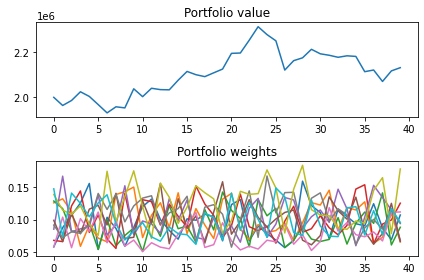

=================================

Initial portfolio value: 1000000

End portfolio value: 1984698.6684345235

Yearly Sharpe ratio at last period: 0.7934267367161306

=================================

Plotting portfolio values and weights for last 40 periods:

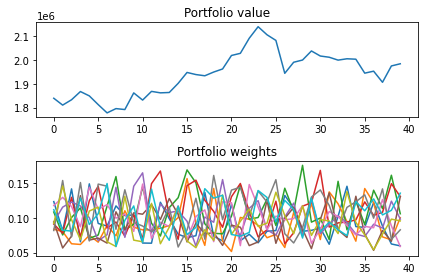

=================================

Initial portfolio value: 1000000

End portfolio value: 1954531.3380786236

Yearly Sharpe ratio at last period: 0.7809294758662636

=================================

Plotting portfolio values and weights for last 40 periods:

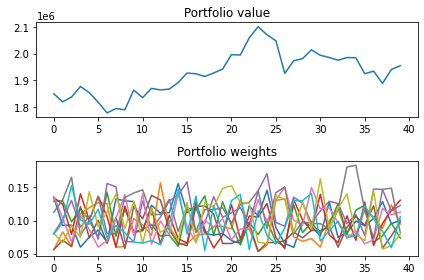

=================================

Initial portfolio value: 1000000

End portfolio value: 2118450.1302494667

Yearly Sharpe ratio at last period: 0.8672017747388964

=================================

Plotting portfolio values and weights for last 40 periods:

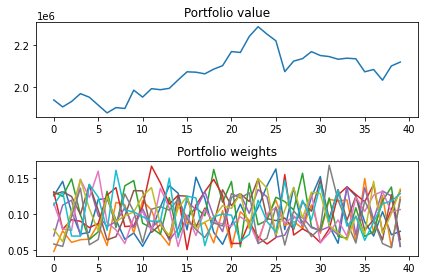

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 0.791    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 267      |
|    time_elapsed    | 56       |
|    total_timesteps | 15108    |
| train/             |          |
|    actor_loss      | -0.335   |
|    critic_loss     | 3.94e-05 |
|    ent_coef        | 0.0487   |
|    ent_coef_loss   | -51.1    |
|    learning_rate   | 0.001    |
|    n_updates       | 3020     |
---------------------------------


In [24]:
%matplotlib inline
SAC_WRet.train_model(tb_log_name='sac',
                     n_train_rounds=12,
                     progress_bar=True,
                    )

Validation period:

Initial portfolio value: 1000000
End portfolio value: 1061434.808651168
Yearly Sharpe ratio at last period: 2.7487266468714293
Plotting portfolio values and weights for last 40 periods:


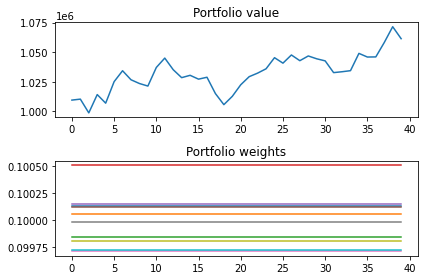

Finished running backtest. Storing results...


In [25]:
val_backtest_result_dict = SAC_WRet.run_backtest(test_env = val_env_ret)

Start date,2020-07-01
End date,2020-08-31
Total months,2
,Backtest
Annual return,41.8%
Cumulative returns,6.1%
Annual volatility,13.2%
Sharpe ratio,2.72
Calmar ratio,11.12
Stability,0.65
Max drawdown,-3.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.76,2020-07-22,2020-07-31,2020-08-10,14
1,1.82,2020-07-06,2020-07-09,2020-07-14,7
2,1.42,2020-08-12,2020-08-19,2020-08-24,9
3,1.25,2020-07-15,2020-07-20,2020-07-21,5
4,0.94,2020-08-28,2020-08-31,NaT,NaN


Stress Events,mean,min,max
New Normal,0.14%,-1.34%,1.80%


True

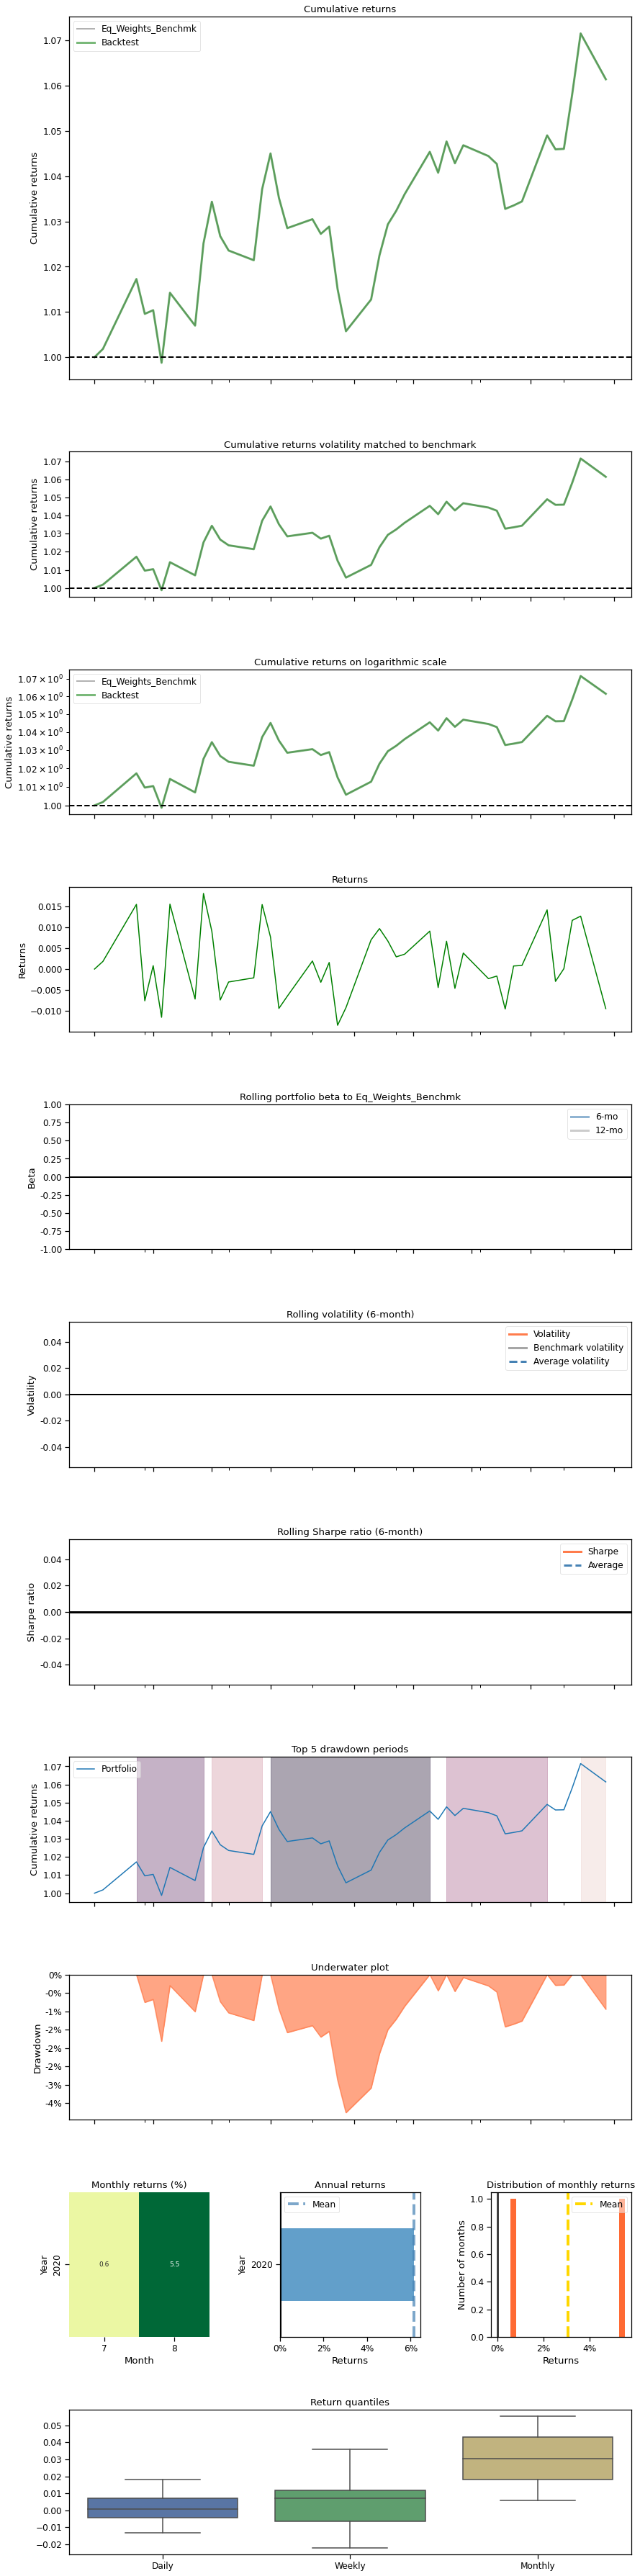

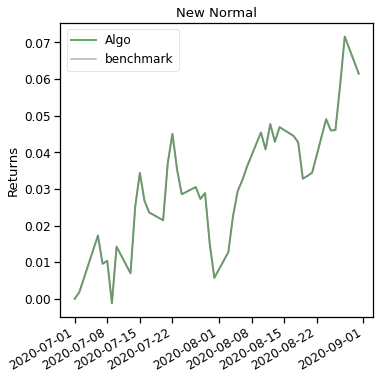

In [26]:
SAC_WRet.plot_backtest_results(df_benchmark_returns=ew_val_benchmark_results_dict["return_hist"],
                               benchmark_name = "Eq_Weights_Benchmk")

<AxesSubplot:>

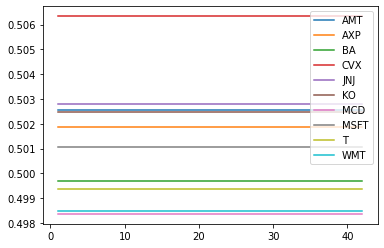

In [27]:
val_backtest_result_dict["agt_actions_hist"].iloc[-42:].plot()

Testing period:

Deleting previous backtest results and history...
Initial portfolio value: 1000000
End portfolio value: 1127797.5033883464
Yearly Sharpe ratio at last period: 1.4304466362224706
Plotting portfolio values and weights for last 40 periods:


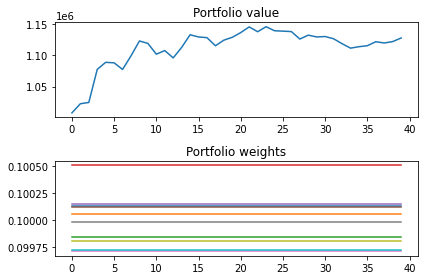

Finished running backtest. Storing results...


In [28]:
test_backtest_result_dict = SAC_WRet.run_backtest(test_env = test_env_ret)

Start date,2020-07-01
End date,2020-12-31
Total months,6
,Backtest
Annual return,26.7%
Cumulative returns,12.8%
Annual volatility,17.7%
Sharpe ratio,1.42
Calmar ratio,2.73
Stability,0.51
Max drawdown,-9.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.78,2020-09-02,2020-10-28,2020-11-10,50
1,3.76,2020-07-22,2020-07-31,2020-08-10,14
2,3.00,2020-12-08,2020-12-22,NaT,NaN
3,2.41,2020-11-16,2020-11-20,2020-11-24,7
4,1.82,2020-07-06,2020-07-09,2020-07-14,7


Stress Events,mean,min,max
New Normal,0.10%,-3.39%,5.17%


True

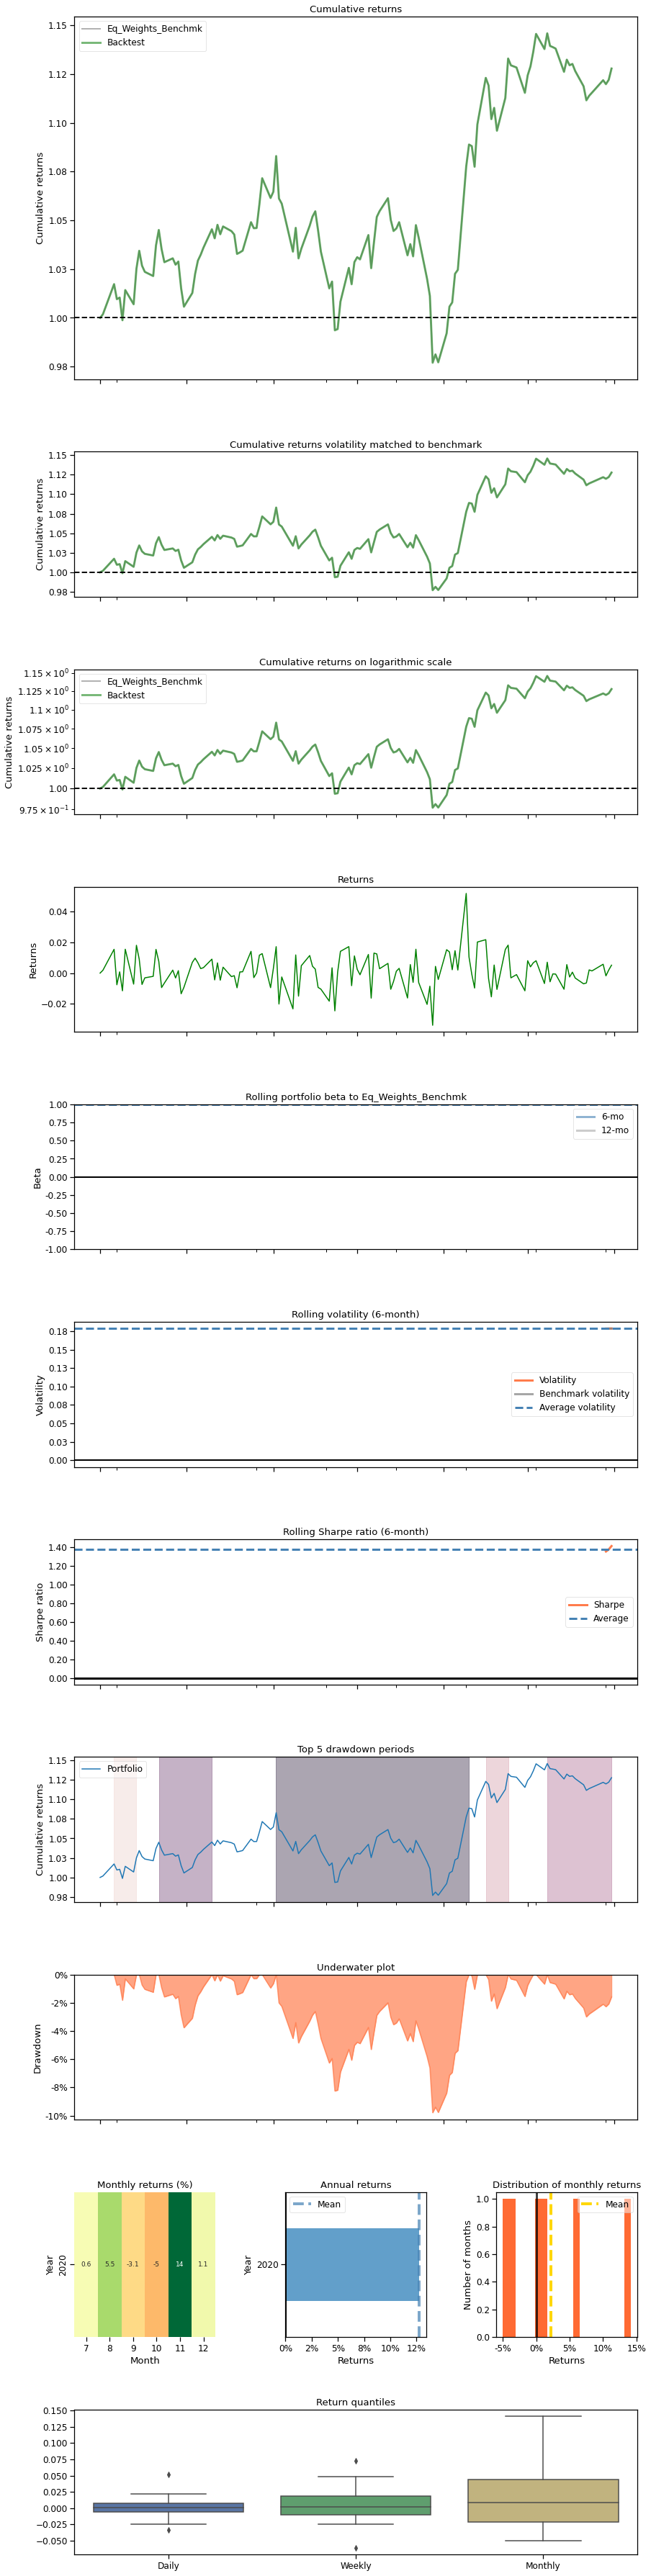

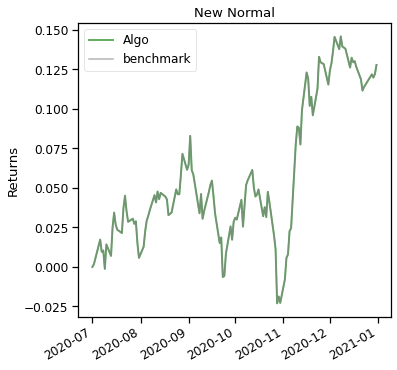

In [29]:
SAC_WRet.plot_backtest_results(df_benchmark_returns=ew_test_benchmark_results_dict["return_hist"],
                               benchmark_name = "Eq_Weights_Benchmk")

<AxesSubplot:>

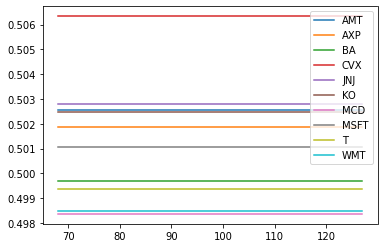

In [30]:
test_backtest_result_dict["agt_actions_hist"].iloc[-60:].plot()

In [ ]:
type(test_backtest_result_dict["agt_actions_hist"])

In [ ]:
test_backtest_result_dict["agt_actions_hist"].columns

<AxesSubplot:>

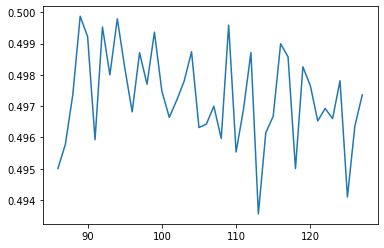

In [134]:
test_backtest_result_dict["agt_actions_hist"]['WMT'].iloc[-42:].plot()

**Aside**

In [11]:
del SAC_WRet

In [12]:
SAC_WRet = PFOpt_DRL_Agent(train_env=train_env_ret)
n_lookback_prds = env_kwargs["n_lookback_prds"]
n_assets = train_env_ret.n_assets
SAC_POLICY = SACDropOutPolicy
SAC_POLICY_KWARGS = {"n_critics":1,
                     "add_input_dropout":True,
                     "net_arch":dict(qf = [2*(n_lookback_prds+2)*n_assets, 10*n_assets],
                                     pi = [2*(n_lookback_prds+1)*n_assets, 10*n_assets, 2*n_assets],
                                    ),
                    }
SAC_MODEL_KWARGS = {"batch_size": 32, 
                    "buffer_size": 10000,
                    "learning_rate": 0.001,
                    "ent_coef": 'auto',
                    "gamma":0,
                    "train_freq": (5, "step"),
                    "learning_starts":5,
                    "action_noise":"ornstein_uhlenbeck",
                   }


In [13]:
SAC_WRet.set_model(model_name = "sac",
                   seed = 196,
                   policy = SAC_POLICY,
                   policy_kwargs=SAC_POLICY_KWARGS,
                   model_kwargs=SAC_MODEL_KWARGS,)

{'batch_size': 32, 'buffer_size': 10000, 'learning_rate': 0.001, 'ent_coef': 'auto', 'gamma': 0, 'train_freq': (5, 'step'), 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

In [14]:
SAC_WRet.model.policy

SACDropOutPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=610, out_features=1220, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1220, out_features=100, bias=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=20, bias=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): ReLU()
    )
    (mu): Linear(in_features=20, out_features=10, bias=True)
    (log_std): Linear(in_features=20, out_features=10, bias=True)
  )
  (critic): DropOutContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=620, out_features=1240, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=1240, out_feat